In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('styleNB.mplstyle')

In [4]:
# load the new construct data
df_filtered = pd.read_csv('../../data/processed_3D_tracking/20240607_compiled_galvaninKOlines_charged-eGFPtracking.csv')

# Include the rescue data
f_rescue_filtered = '../../data/processed_3D_tracking/20240424_compiled_galvaninKOlines_rescue_tracking_GFPplus.csv'
df_gfp = pd.read_csv(f_rescue_filtered)
df_gfp = df_gfp[['cell', 'frame', 'x', 'y', 'z',
       'celltype', 'E_V_cm', 'date', 'trial', 'user']]

df_concat = pd.concat([df_filtered, df_gfp], ignore_index = True)

# remove cells at the periphery
df_concat_ = pd.DataFrame()
for g, d_ in df_concat.groupby(['celltype', 'E_V_cm', 'date', 'trial', 'user', 'cell']):
    if np.any(d_.z > 290):
        continue
    elif np.any(d_.z < 10):
        continue
    
    # Append the row to the DataFrame using concat
    df_concat_ = pd.concat([df_concat_, d_], ignore_index=True)

In [9]:

def non_overlapping_normalized_autocorrelation(signal):
    """
    Calculate the non-overlapping normalized autocorrelation of a 1D signal.
    
    Parameters:
    signal (np.ndarray): Input 1D signal.
    
    Returns:
    np.ndarray: Non-overlapping normalized autocorrelation values.
    """
    n = len(signal)
    autocorrelation = np.zeros(n)
    
    for lag in range(n):
        sum_product = 0
        count = 0
        for i in range(0, n - lag, lag + 1):
            sum_product += signal[i] * signal[i + lag]
            count += 1
        
        if count > 0:
            # Normalizing with respect to the sum of squares for lag 0
            normalization_factor = np.sqrt(np.sum(signal[:n - lag:lag + 1] ** 2) * np.sum(signal[lag:n:lag + 1] ** 2))
            autocorrelation[lag] = sum_product / normalization_factor if normalization_factor != 0 else 0
    
    return autocorrelation


###############################
# directionality calculation
# https://stackoverflow.com/questions/2827393/angles-between-two-n-dimensional-vectors-in-python
###############################
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0)) 

array(['dHL60TMEM154KO-clone1+9GFP-galvanin-HA',
       'dHL60TMEM154KO-clone1-30GFP-galvanin-HA',
       'dHL60TMEM154KO-clone1galvanin-GFP-HA'], dtype=object)

In [16]:

df_angle_E_3_ = pd.DataFrame()

for g, d_ in df_concat_.groupby(['celltype', 'E_V_cm', 'date', 'trial', 'user', 'cell']):

    if len(np.arange(d_.frame.min(), d_.frame.max())) + 1 != len(d_.frame.unique()):
        continue
    else:
        # Iterate over frames with a step size of 3
        for t in np.arange(d_.frame.min() + 3, d_.frame.max() + 1, 3):
            if (t - 3) < d_.frame.min():  # Ensure there's enough data for the intervals
                continue
            
            vec_t1 = [d_[d_.frame == t-3].x.values[0] - d_[d_.frame == t].x.values[0],
                      d_[d_.frame == t-3].y.values[0] - d_[d_.frame == t].y.values[0]]
            vec_t2 = [3, 0]  # reference vector (magnitude not important)

            datalist = {'celltype': g[0],
                        'E_V_cm': g[1],
                        'date': g[2],
                        'trial': g[3],
                        'user': g[4],
                        'cell': g[5],
                        'interval': t,
                        'angle': angle_between(vec_t2, vec_t1),
                        'cos_angle': np.cos(angle_between(vec_t2, vec_t1))}
            df_dict = pd.DataFrame([datalist])
            df_angle_E_3_ = pd.concat([df_angle_E_3_, df_dict], ignore_index=True)

/var/folders/hs/8f67z23n6g9g9g4y03yhrn_c0000gn/T/ipykernel_6663/3644168872.py:36: RuntimeWarning: invalid value encountered in true_divide
  return vector / np.linalg.norm(vector)
/var/folders/hs/8f67z23n6g9g9g4y03yhrn_c0000gn/T/ipykernel_6663/3644168872.py:36: RuntimeWarning: invalid value encountered in true_divide
  return vector / np.linalg.norm(vector)


In [17]:
color_dict = {'dHL60KW': '#B8BABC',
              'dHL60TMEM154KO': (1.0, 0.4980392156862745, 0.054901960784313725),
              'dHL60TMEM154KO-clone1galvanin-GFP-HA': (0.17254901960784313,  0.6274509803921569, 0.17254901960784313),
             'dHL60TMEM154KO-clone1+9GFP-galvanin-HA': (0.12156862745098039,0.4666666666666667, 0.7058823529411765),
             'dHL60TMEM154KO-clone1-30GFP-galvanin-HA': 'k'}

dHL60TMEM154KO-clone1+9GFP-galvanin-HA
dHL60TMEM154KO-clone1-30GFP-galvanin-HA
dHL60TMEM154KO-clone1galvanin-GFP-HA


Text(0, 0.5, 'directional\nautocorrelation\n(6 min. time lag)')

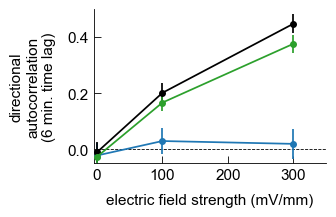

In [25]:
df_acf = pd.DataFrame()

for g, d in df_angle_E_3_.groupby(['celltype', 'E_V_cm']):
    
    acf_all = np.zeros(8)
    for g_, d_ in d.groupby(['date', 'trial', 'user', 'cell']):
        d_ = d_.sort_values('interval')
        y = d_.cos_angle.values

        # need each array to be same length (take only full length 
        # tracks, or ones missing an interval)
        if len(y) > 8:
            y = y[:8]
        if len(y) != 8:
            continue
            
        acf = [1] #initializing list with autocorrelation coefficient for lag k=0 which is always 1
        acf = non_overlapping_normalized_autocorrelation(y) #calling autocorr function for each lag 'i'

        acf_all = np.vstack([acf_all, acf])

    data_list = {'celltype': g[0],
                 'E_V_cm' : g[1],
                'autocorr_0' : acf_all[:,0],
                'autocorr_1' : acf_all[:,1],
                'autocorr_2' : acf_all[:,2],
                'autocorr_3' : acf_all[:,3],
                'autocorr_4' : acf_all[:,4],
                'autocorr_5' : acf_all[:,5]}
    
    df_dict = pd.DataFrame([data_list])
    df_acf = pd.concat([df_acf, df_dict], ignore_index=True)



f, ax = plt.subplots(1,1, figsize = (3,2))

for g, d in df_acf.groupby('celltype'):
    print(g)
    ax.errorbar(x = d.E_V_cm.values[:-1]*100,
                   y = [np.mean(x) for x in d.autocorr_2.values][:-1], 
                   yerr = [np.std(x)/np.sqrt(len(x)) for x in d.autocorr_2.values][:-1],
                   label = g, 
                  zorder = 10, lw = 1.25, marker = 'o', markersize = 4,
                color = color_dict[g])

    
plt.xlim(-5,350)
plt.ylim(-0.05,0.5)

# plt.legend()


ax.hlines(0,0,400, zorder = 0, color = 'k', linestyle = '--')

ax.set_xlabel('electric field strength (mV/mm)')
ax.set_ylabel('directional\nautocorrelation\n(6 min. time lag)')


# # Shrink current axis by 20%
# box = ax.get_position()
# ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# plt.savefig('../../figures/Figure5_autocorr_.pdf')